In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as onp
import itertools
import datetime
import tqdm
import sys
import os

import jax.numpy as np

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


In [2]:
class Patient:
    susceptible = 0
    colonized   = 1

class Observed:
    no  = 0
    yes = 1

In [3]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df               = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"] = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df               = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id  = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id = {ward_name: id for id, ward_name in enumerate(movement_df.ward_total.unique())}

movement_df["mrn_id"]  = movement_df.mrn.map(mrd2id)
movement_df["ward_id"] = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_22333/2813536434.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [4]:
from jax import random

Np  = 10000
key = random.PRNGKey(0)


In [5]:
from jax import random

def decolonize(agents_state, alpha, Np):
    return agents_state - agents_state * (random.uniform(key=key, shape=(Np, )) < alpha)

def amr_abm(agents_state, movement, ward2size, parameters):
    """ Agent based model tracking colonized and susceptible patients with pre-defined movement patterns.

    Args:
        agents_state : agent state. {0: Patient.susceptible, 1: Patient.colonized}  Size: (n_patients)
        movement     : pd.Dataframe with patient locations and culture information.
        parameters   : dictionary of parameters, contains importation rate (gamma), nosocomial transmission rate (beta),
                        effective sensitivity (ro), and decolonization rate (alpha)
    """
    agents_state = onp.array(agents_state)

    γ   = parameters["gamma"] # importation rate.
    β   = parameters["beta"]  # nosocomial transmission rate.
    ρ   = parameters["ro"]    # effective sensitivity.
    α   = parameters["alpha"] # decolonization rate
    Nw  = parameters["Nw"]    # number of wards
    Np  = parameters["Np"]    # number of patients

    # Decolonize patients according to. P(C2S) = α
    #agents_state.at[:].set(np.maximum(agents_state - agents_state * (random.uniform(key=key, shape=(Np, )) < α), 0))
    #agents_state = agents_state - agents_state * (onp.random.uniform(size=(Np, )) < α)
    p_update = agents_state.copy()
    p_update = Patient.susceptible * (agents_state * onp.random.random(size=(Np, )) <= α)

    # import patients.
    new_patients = movement[movement["first_day"]==1]["mrn_id"].values
    if new_patients.shape[0] > 0:
        # P(S2C) = \gamma - Probability of colonization given importation.
        #agents_state[new_patients] = Patient.colonized * (random.uniform(key=key, shape=(new_patients.shape[0], )) < γ)
        p_update[new_patients] = Patient.colonized * (onp.random.random(size=(new_patients.shape[0], )) <= γ)

    # Compute force of infection for each ward.
    for i, ward_id in enumerate(movement["ward_id"].unique()):
        patients_ward = movement[movement["ward_id"]==ward_id]["mrn_id"].values

        # λ_i = β  * C / N  - Force of infection for ward i.
        λ_i = β * onp.sum(p_update[patients_ward]==Patient.colonized) / ward2size[ward_id]

        # P(C2S)_i = λ_i, we add the state but if already colonized the state would be 2 so we clip it to 1.
        #agents_state[patients_ward] = Patient.colonized * np.minimum(agents_state[patients_ward] + random.uniform(key=key, shape=(patients_ward.shape[0], )) < λ_i, 1)
        p_update[patients_ward] = p_update[patients_ward] + Patient.colonized * (onp.random.random(size=(patients_ward.shape[0], )) <= λ_i)
    p_update = onp.clip(p_update, 0, 1)

    return p_update


100%|██████████| 394/394 [00:18<00:00, 21.79it/s]


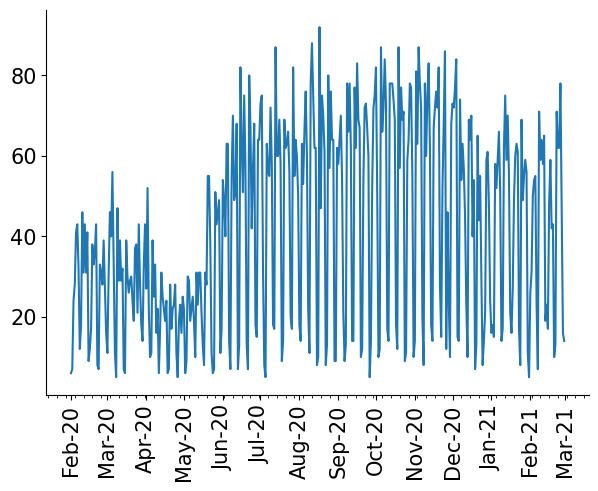

In [6]:
from jax import jit, vmap

dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

parameters          = {}
parameters["gamma"] = 5/100
parameters["beta"]  = 0.02
parameters["ro"]    = 6/100
parameters["alpha"] = 1/120
parameters["Nw"]    = len(ward2id)
parameters["Np"]    = movement_df.mrn_id.unique().shape[0]

colonized    = []

key   = random.PRNGKey(0)
model = lambda pstatus, movement: amr_abm(pstatus, movement, ward2size, parameters)

from tqdm import tqdm
import numpy as onp

agents_state = onp.zeros(parameters["Np"])

for date in tqdm(dates_simulation):
    movement     = movement_df[movement_df["date"]==date]
    agents_state = model(agents_state, movement)
    colonized.append(np.sum(agents_state==Patient.colonized))

from utils.plot_utils import *

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(dates_simulation, colonized)
format_axis(ax)


In [13]:
from jax import random

def amr_abm(agents_state, movement, ward2size, parameters):
    """ Agent based model tracking colonized and susceptible patients with pre-defined movement patterns.

    Args:
        agents_state : agent state. {0: Patient.susceptible, 1: Patient.colonized}  Size: (n_patients)
        movement     : pd.Dataframe with patient locations and culture information.
        parameters   : dictionary of parameters, contains importation rate (gamma), nosocomial transmission rate (beta),
                        effective sensitivity (ro), and decolonization rate (alpha)
    """
    _, m = agents_state.shape

    γ   = parameters["gamma"] # importation rate.
    β   = parameters["beta"]  # nosocomial transmission rate.
    ρ   = parameters["ro"]    # effective sensitivity.
    α   = parameters["alpha"] # decolonization rate
    Nw  = parameters["Nw"]    # number of wards
    Np  = parameters["Np"]    # number of patients

    # Decolonize patients according to. P(C2S) = α
    #agents_state.at[:].set(np.maximum(agents_state - agents_state * (random.uniform(key=key, shape=(Np, )) < α), 0))
    #agents_state = agents_state - agents_state * (onp.random.uniform(size=(Np, )) < α)
    p_update = agents_state.copy()
    p_update = Patient.susceptible * (agents_state * onp.random.random(size=(Np, m)) <= α)

    # import patients.
    new_patients = movement[movement["first_day"]==1]["mrn_id"].values
    if new_patients.shape[0] > 0:
        # P(S2C) = \gamma - Probability of colonization given importation.
        #agents_state[new_patients] = Patient.colonized * (random.uniform(key=key, shape=(new_patients.shape[0], )) < γ)
        p_update[new_patients, :] = Patient.colonized * (onp.random.random(size=(new_patients.shape[0], m)) <= γ)

    # Compute force of infection for each ward.
    for i, ward_id in enumerate(movement["ward_id"].unique()):
        patients_ward = movement[movement["ward_id"]==ward_id]["mrn_id"].values

        # λ_i = β  * C / N  - Force of infection for ward i.
        λ_i = β * onp.sum(p_update[patients_ward,:]==Patient.colonized, axis=0) / ward2size[ward_id]

        # P(C2S)_i = λ_i, we add the state but if already colonized the state would be 2 (colonized via both importation and admissions) so we clip it to 1.
        #agents_state[patients_ward] = Patient.colonized * np.minimum(agents_state[patients_ward] + random.uniform(key=key, shape=(patients_ward.shape[0], )) < λ_i, 1)
        p_update[patients_ward, :] = p_update[patients_ward, :] + Patient.colonized * (onp.random.random(size=(patients_ward.shape[0], m)) <= λ_i)

    p_update = onp.clip(p_update, 0, 1)
    return p_update

def observe_ward(patients_state, movement, parameters):
    _, m = patients_state.shape
    ρ    = parameters["ro"] # effective sensitivity.
    Nw   = parameters["Nw"] # number of wards

    ward_colonized = onp.zeros((Nw, m))
    ward_positive  = onp.zeros((Nw, m))

    p_test = Observed.yes * (onp.random.random(size=(patients_state.shape[0], m)) <= patients_state * ρ)

    for i, ward_id in enumerate(movement["ward_id"].unique()):

        patients_ward      = movement.query(f"ward_id=={ward_id}")["mrn_id"].values
        patients_test_ward = movement.query(f"ward_id=={ward_id} and test==True")["mrn_id"].values

        ward_colonized[ward_id, :] = onp.sum(patients_state[patients_ward, :] == Patient.colonized, axis=0)
        ward_positive[ward_id,  :] = onp.sum(p_test[patients_test_ward, :]    == Observed.yes, axis=0)

    return ward_colonized, ward_positive

In [15]:
parameters          = {}
parameters["gamma"] = 5/100
parameters["beta"]  = 0.02
parameters["ro"]    = 6/100
parameters["alpha"] = 1/120
parameters["Nw"]    = len(ward2id)
parameters["Np"]    = movement_df.mrn_id.unique().shape[0]

# Function to be used for the ikeafk function.
# f_if  = lambda t, x, θ: f(t, x, θ[0, :], θ[1, :], N)
# g_if  = lambda t, x, θ: g(t, x, θ[2, :])
# f0_if = lambda θ: f0(pop=N, inf_init=10/100, m=model_settings["m"])

m               = 300
agents_state    = onp.zeros((movement_df.mrn_id.unique().shape[0], m))
ward_colonized  = np.full((len(dates_simulation), parameters["Nw"], m), np.nan)
ward_positive   = np.full((len(dates_simulation), parameters["Nw"], m), np.nan)

for i, date in enumerate(dates_simulation):
    movement                      = movement_df[movement_df["date"]==date]
    agents_state                  = amr_abm(agents_state, movement, ward2size, parameters)
    ward_colonized[i, : ], ward_positive[i, :] = observe_ward(agents_state, movement, parameters)

In [20]:
ward_size_df.tail(13)

,ward,ward_id,num_patients
20,Aln Emergency,32,28.786082
181,Pby 14 Transplant Infusion Center,12,37.910448
56,Hrt 4 Col Proc Card Med,10,51.944637
139,Msch 10 L And D,23,54.868020
192,Pby Radiation Oncology,27,58.446429
41,Hip 14 Adult Infusion,11,59.136029
128,Mil Operating Room,22,69.020408
63,Hrt Myrna Daniels Infusion,4,88.151515
162,Msch Emergency,20,92.875635
184,Pby Adult Emergency,0,120.164975


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_22333/3355527216.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wk_c_df = c_df.resample("W-Sun").sum()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_22333/3355527216.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wk_c_df = c_df.resample("W-Sun").sum()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_22333/3355527216.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns whic

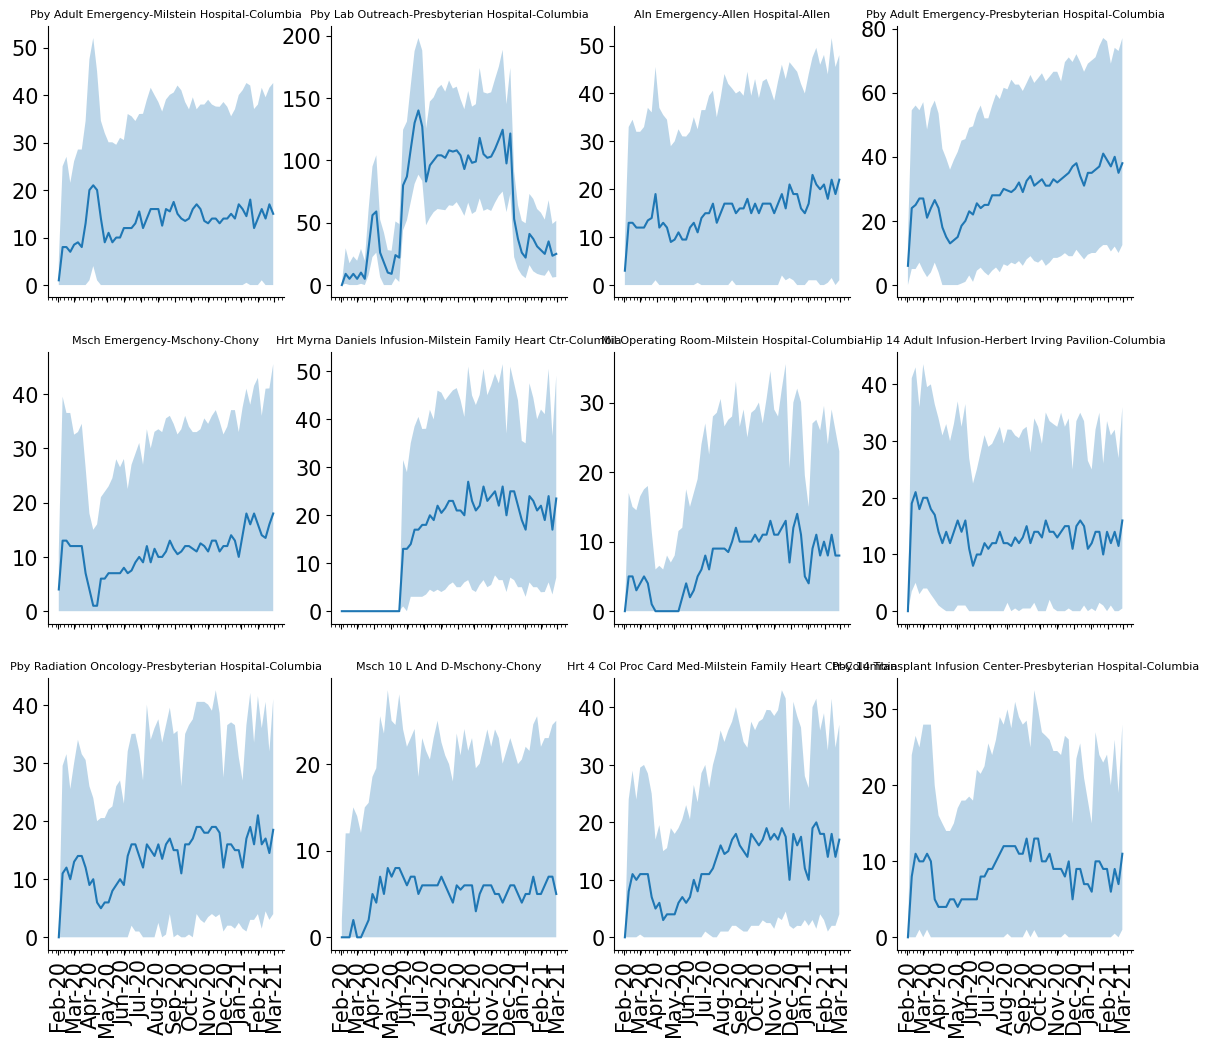

In [21]:
from utils.infer_utils import create_df_response

big_wards = [8, 13, 1, 0, 20, 4, 22, 11, 27, 23, 10, 12]

fig, axes = plt.subplots(3, 4, figsize=(14, 12), sharex=True)
for iax, ax in enumerate(axes.flatten()):

    c_df    = create_df_response(ward_colonized[:, big_wards[iax], :].T, time=len(dates_simulation), dates=dates_simulation)
    wk_c_df = c_df.resample("W-Sun").sum()

    ax.plot(wk_c_df.index.values, wk_c_df["median"])
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_95"], wk_c_df["high_95"], alpha=0.3)

    ax.set_title(movement_df.query(f"ward_id=={big_wards[iax]}")["ward_total"].values[0], fontsize=8)
    format_axis(ax)


In [22]:
fig, axes = plt.subplots(3, 4, figsize=(14, 9), sharex=True)
for iax, ax in enumerate(axes.flatten()):

    c_df    = create_df_response(ward_positive[:, big_wards[iax], :].T, time=len(dates_simulation), dates=dates_simulation)
    wk_c_df = c_df.resample("W-Sun").sum()

    ax.plot(wk_c_df.index.values, wk_c_df["median"])
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_95"], wk_c_df["high_95"], alpha=0.3)

    ax.set_title(movement_df.query(f"ward_id=={big_wards[iax]}")["ward_total"].values[0], fontsize=8)
    format_axis(ax)

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_22333/2068044322.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wk_c_df = c_df.resample("W-Sun").sum()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_22333/2068044322.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wk_c_df = c_df.resample("W-Sun").sum()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_22333/2068044322.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns whic

In [ ]:
# DEFINITION OF CARRIGE, BURN-IN TIME THE FIRST 4 WEEKS, ALL BUILDINGS THAT ARE ONLY OUTPATIENTS. EMAIL JASON ZUCKER.
## TRY INFERENCE WITH DIFFERENT DATA MANIPULATION/PREPROCESSING.